In [334]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

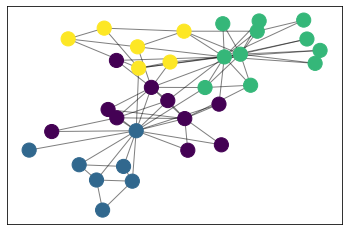

In [335]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
# gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [336]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))
gatewayGraph=nx.Graph()
gatewayGraph.add_edges_from(gateEdges)

Gateway graph nodes: [2, 1, 3, 4, 8, 9, 13, 14, 18, 20, 22, 28, 29, 30, 24, 31, 32, 33, 34, 10]


In [337]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
tot_graphs=[]
for i in range(0,500):
    g = G
    gatew = gatewayGraph
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in G.edges()}
    nx.set_edge_attributes(g, attr)
    tot_g.append(g.subgraph(gatew))
    tot_graphs.append(g)
# for k in range(0,500):
#     print(len(tot_g[k]))
#     tot_g[k].add_nodes_from(gateNodesList)
#     print(len(tot_g[k]))
#     for i in range(0,len(gateEdges)):
#         tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))
#     break

In [338]:
#BCS Score
def BCS(gg,nodes,nodeList):
    BCS_={}
    for node in nodeList:
        BCS_[node]=0
    for i in gg:
        x=(nx.betweenness_centrality(i,weight='weight'))
        for j in x:
            BCS_[j]+=(1/500)*x[j]
    return BCS_
BCS_value=BCS(tot_g,len(gateNodesList),gateNodesList)
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 0.39619883040935955), (34, 0.3698830409356684), (20, 0.25000000000000017), (4, 0.24561403508771829), (3, 0.21198830409356628), (28, 0.20906432748538087), (2, 0.09795321637426999), (24, 0.07748538011695877), (32, 0.05116959064327435), (8, 0.0), (9, 0.0), (13, 0.0), (14, 0.0), (18, 0.0), (22, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (33, 0.0), (10, 0.0)]


In [339]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']
valf=-1
for x in time_of_diffusion:
    if time_of_diffusion[x]==0:
        valf=x    

100%|██████████| 200/200 [00:00<00:00, 2409.76it/s]


In [340]:
print(time_of_diffusion)

{1: 51, 2: 46, 3: 37, 4: 49, 5: 57, 6: 80, 7: 73, 8: 42, 9: 49, 10: 58, 11: 72, 12: 52, 13: 63, 14: 40, 15: 52, 16: 71, 17: 77, 18: 57, 19: 40, 20: 43, 21: 63, 22: 53, 23: 56, 24: 0, 25: 19, 26: 4, 27: 46, 28: 21, 29: 48, 30: 42, 31: 49, 32: 8, 33: 38, 34: 36}


In [341]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[1, 34, 20]
[2, 1, 3, 4, 8, 9, 13, 14, 18, 20, 22, 28, 29, 30, 24, 31, 32, 33, 34, 10]
50


In [342]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[15, 7]


50


100%|██████████| 200/200 [00:00<00:00, 3278.85it/s]


100%|██████████| 200/200 [00:00<00:00, 3448.71it/s]


100%|██████████| 200/200 [00:00<00:00, 3773.74it/s]


[4.069523346903554e-07, 1.2090403501884877e-06, 2.5944237079994087e-09, 5.8630327426740485e-05, 9.027379761420704e-08, 6.237570968624561e-10, 7.124327843848701e-06, 1.1650064285314627e-31, 5.494526422530853e-06, 1.456258035664328e-31, 1.456258035664328e-31, 2.4957443455201753e-07, 1.1967084672469915e-05, 9.01070264604098e-08, 6.334264970729028e-07, 5.350773326619514e-07, 1.4074548804866448e-07, 1.3106322633849843e-31, 1.625526150165089e-06, 2.0731835518752436e-05]


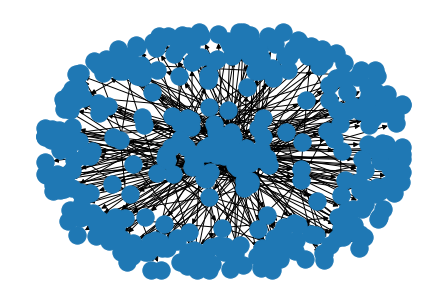

In [343]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=0
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 0.07)
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)
        
        time_of_diffusion_={}
        for i in range(1,node+1):
            time_of_diffusion_[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_[j]=i['iteration']
        
        for node in gateNodesList:
            if node not in time_of_diffusion_.keys(): 
                time_of_diffusion_[node]=-1
        
        min_v=min([time_of_diffusion_[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion_[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion_[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion_[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion_[sensor])
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val) 
        sub = np.subtract(delta_t,mu)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax+=fun
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)

In [344]:
print(allDiffusionTime)

[]


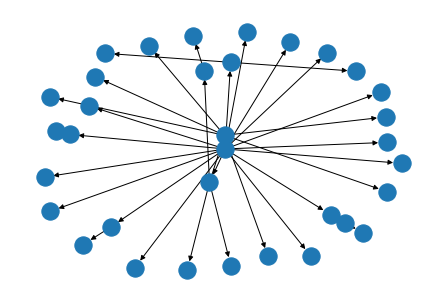

In [345]:
nx.draw(nx.bfs_tree(g, source = 1))

In [346]:
print(len(toTakeArgmax))
print(toTakeArgmax)

20
[4.069523346903554e-07, 1.2090403501884877e-06, 2.5944237079994087e-09, 5.8630327426740485e-05, 9.027379761420704e-08, 6.237570968624561e-10, 7.124327843848701e-06, 1.1650064285314627e-31, 5.494526422530853e-06, 1.456258035664328e-31, 1.456258035664328e-31, 2.4957443455201753e-07, 1.1967084672469915e-05, 9.01070264604098e-08, 6.334264970729028e-07, 5.350773326619514e-07, 1.4074548804866448e-07, 1.3106322633849843e-31, 1.625526150165089e-06, 2.0731835518752436e-05]


In [347]:
finArg = np.argmax(toTakeArgmax,axis=0)
print(finArg)

3


In [348]:
id=-1
mx=-1
for i in range(0,len(toTakeArgmax)):
    if(toTakeArgmax[i]>mx):
        mx=toTakeArgmax[i]
        id=i
clusterNode=gateNodesList[id]

In [349]:
partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])

0


In [350]:
print(partition[valf])

3


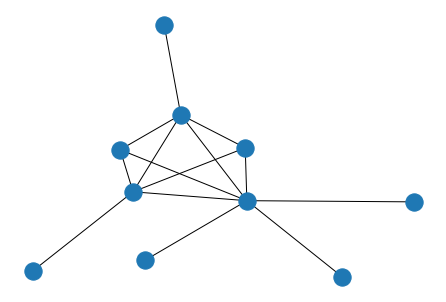

In [351]:
candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

In [352]:
myset=set([])
for e in candidateCluster:
    myset.add(e[0])
    myset.add(e[1])
print(myset)
my=[]
for ele in myset:
    my.append(ele)
print("list",my)


{2, 3, 4, 8, 10, 13, 14, 18, 20, 22}
list [2, 3, 4, 8, 10, 13, 14, 18, 20, 22]


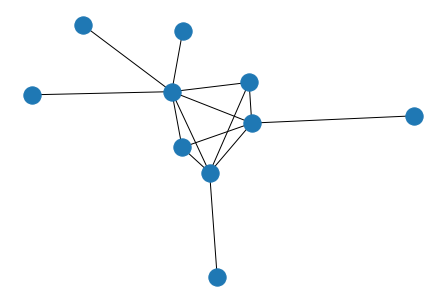

In [353]:
cG = G.subgraph(my)
nx.draw(cG)

500


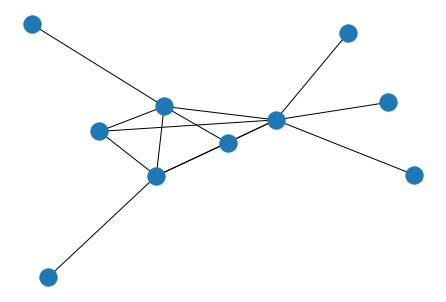

In [354]:
tot_cg_set=set([])
for i in range(0,500):
    tot_cg_set.add(tot_graphs[i].subgraph(my))
print(len(tot_cg_set))
tot_cg=[]
for g in tot_cg_set:
    tot_cg.append(g)
# print(len(tot_cg))
nx.draw(tot_graphs[7].subgraph(my))

In [355]:
print(len(cG.edges()))
nodes_in_cg=[]
nodes_in_cg_set=set([])
for ee in cG.edges():
    nodes_in_cg_set.add(ee[0])
    nodes_in_cg_set.add(ee[1])
for ele in nodes_in_cg_set:
    nodes_in_cg.append(ele)
print("nodes_in_cg",nodes_in_cg)
print(len(tot_cg[0]))
BCS_value_cg=BCS(tot_cg,len(tot_cg)+2,nodes_in_cg)
BCS_value_cg=(sorted(BCS_value_cg.items(), key=lambda x: x[1],reverse=True))

14
nodes_in_cg [2, 3, 4, 8, 10, 13, 14, 18, 20, 22]
10


In [356]:
# Model selection - diffusion time
model = ep.SIModel(cG)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in cG.edges()]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion_cg={}
for i in range(1,node+1):
    time_of_diffusion_cg[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion_cg[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 2941.36it/s]


In [357]:
print(time_of_diffusion_cg)

{1: -1, 2: 152, 3: 107, 4: 140, 5: -1, 6: -1, 7: -1, 8: 141, 9: -1, 10: 0, 14: 137, 13: 158, 18: 167, 22: 180, 20: 189}


In [358]:
sensor_nodes_cg=[BCS_value_cg[i][0] for i in range(0,3)]
print(sensor_nodes_cg)

[2, 4, 3]


In [359]:
delta_t_cg=[]
min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
min_n_cg=-1
for i in sensor_nodes_cg:
    if(time_of_diffusion_cg[i]==min_v_cg):
        min_n_cg=i
        break
delta_t_cg=[abs(time_of_diffusion_cg[i]-min_v_cg) for i in sensor_nodes_cg if(i!=min_n_cg)]
print(delta_t_cg)

[45, 33]


100%|██████████| 200/200 [00:00<00:00, 7143.80it/s]


100%|██████████| 200/200 [00:00<00:00, 8001.19it/s]


[3.978668819457088e-05, 3.8207044419433583e-07, 1.0193806249650302e-31, 6.237570968624561e-10, 3.690304341689072e-07, 8.512259081937288e-06, 7.598477769558324e-06, 2.1202488565847494e-06, 5.4522104767743156e-06, 3.5979116666034136e-05]


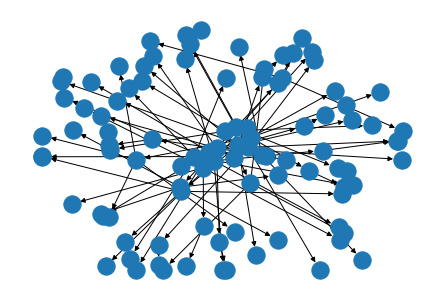

In [360]:
g___cg = nx.Graph()
g___cg.add_edges_from(cG.edges())
# allDiffusionTime = []
mcaps_cg=[tot_cg[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax_cg=[]
for node in nodes_in_cg:
#     print(node)
    bfs_tree = nx.bfs_tree(g___cg, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax_cg=0
    for mcap_cg in mcaps_cg:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion_cg={}
        for i in range(1,node+1):
            time_of_diffusion_cg[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_cg[j]=i['iteration']
        
        for node in nodes_in_cg:
            if node not in time_of_diffusion_cg.keys(): 
                time_of_diffusion_cg[node]=-1
        
        min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
        min_n_cg=-1
        for i in sensor_nodes_cg:
            if(time_of_diffusion_cg[i]==min_v_cg):
                min_n_cg=i
                break
        mu_cg=[abs(time_of_diffusion_cg[i]+min_v_cg)/2 for i in sensor_nodes_cg if(i!=min_n_cg)]
#         print(len(delta_t_cg),len(mu_cg))
        
        arrivals_cg=[]
        
        for sensor in sensor_nodes_cg:
            if(time_of_diffusion_cg[sensor]==-1):
                arrivals_cg.append(200)
            else:
                arrivals_cg.append(time_of_diffusion_cg[sensor])
                
#         print("arrivals_cg",arrivals_cg)
                
        new_delta_ts_cg = []
            
        for i in range(0,len(arrivals_cg)):
            new_delta_t_cg=[]
            for j in range(0,len(arrivals_cg)):
                if(i!=j):
                    new_delta_t_cg.append(abs(arrivals_cg[j]-arrivals_cg[i]))
            new_delta_ts_cg.append(new_delta_t_cg)
#             print("new_delta_ts_cg",new_delta_ts_cg)
#         print(new_delta_ts_cg)
            
        lambd_cg = []
        for i in range(0,len(new_delta_ts_cg)-1):
#             print("---> ",len(new_delta_ts_cg[i]),len(new_delta_ts_cg[i+1]))
            val_cg = np.correlate(new_delta_ts_cg[i],new_delta_ts_cg[i+1],"same")
            for i in range(0,len(val_cg)):
                if (val_cg[i]==0):
                    val_cg[i]=1
            lambd_cg.append(val_cg)
#         print("lambd_cg",lambd_cg)
#         print("delta_t_cg",delta_t_cg,"mu_cg",mu_cg)    
        sub_cg = np.subtract(delta_t,mu_cg)
#         print("sub_cg",sub_cg)
        lambd_cg[0][1]=0
        powerOfe_cg = np.dot(np.dot((sub_cg), np.linalg.inv(lambd_cg) ),np.transpose(sub_cg))
#         print("powerOfe_cg",powerOfe_cg)
        powerOfe_cg=abs(powerOfe_cg)
        fun_cg = (1/np.linalg.det(lambd_cg))*np.exp(-(1/2)*powerOfe_cg)
        vecOfArgmax_cg+=fun_cg
    toTakeArgmax_cg.append(vecOfArgmax_cg)
print(toTakeArgmax_cg)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [361]:
print(len(toTakeArgmax_cg))
print(toTakeArgmax_cg)

10
[3.978668819457088e-05, 3.8207044419433583e-07, 1.0193806249650302e-31, 6.237570968624561e-10, 3.690304341689072e-07, 8.512259081937288e-06, 7.598477769558324e-06, 2.1202488565847494e-06, 5.4522104767743156e-06, 3.5979116666034136e-05]


In [362]:
finArg_cg = np.argmax(toTakeArgmax_cg,axis=0)

In [363]:
id_cg=-1
mx_cg=-1
for i in range(0,len(toTakeArgmax_cg)):
    if(toTakeArgmax_cg[i]>mx_cg):
        mx_cg=toTakeArgmax_cg[i]
        id_cg=i
source_node=nodes_in_cg[id_cg]
print(source_node,valf)

2 24


In [364]:
print(partition[source_node])
print(partition[valf])

0
3


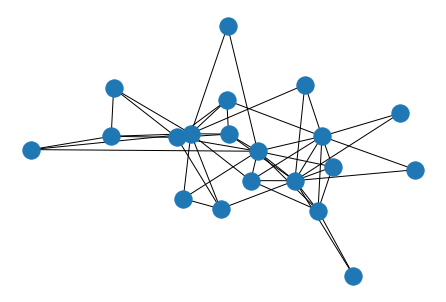

In [365]:
nx.draw(G.subgraph(gatew))